<a href="https://colab.research.google.com/github/sfrancey/Real-or-Not-NLP-with-Disaster-Tweets_Team_Blancpain/blob/main/Code/Final_Notebook_predict_real_disaster_TeamBlancpain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DM&ML TEAM BLANCPAIN**

The Team 🕵🏻‍♂️🕵🏼🕵🏻‍♂️


*   Gabin Flourac
*   Sixtine Francey
*   Alexandre Keusen 





The Project ⚙️

Our challenge is to build a Machine Learning Model that aim to predict which tweets are about a real (natural) disaster and which are not.

To do so, we have access to a dataset of 6,471 tweets classified between real disasters (1) and not real disasters (0).

Our results are compared among all teams involved in this competition in order to get the best prediction possible.



Our best results per iteration🏆


*   **iteration 1**: Base Rate → 0.572
*   **iteration 2**: Logistic Regression - Keyword - TFIDF : 0.74 (↗)
*   **iteration 3**: Logistic Regression - Text (with stopwords and punctuation) - TFIDF (*AICrowd*): 0.817 (↗)
*   **iteration 4**: Logistic Regression - Text (with stopwords and punctuation) + Selected Keywords - TFIDF (*AICrowd*) : 0.818 (↗)
*   **iteration 5**: kNN - Text + Selected keywords + Selected locations - TFIDF : 0.77 (-)
*   **iteration 6**: Logistic Regression - Text + Selected Keywords + Selected Locations - TFIDF (*AICrowd*): 0.818 (↗)
*   **iteration 7.1** Logistic Regression - cleaning emojis - TFIDF : 0.804 (↘)
*   **iteration 7.2** Logistic Regression - spelling correction - TFIDF : 0.79 (↘)







Graphic of our various tests 🗒

In [ ]:
import pandas as pd
table = pd.read_csv('https://raw.githubusercontent.com/sfrancey/Real-or-Not-NLP-with-Disaster-Tweets_Team_Blancpain/main/Data/tableau.csv',sep=";")
table

,Analysé,smileys,parameters,model,features,result
0,keyword,non,stopwords,log,w2v,0.57
1,keyword,non,punctuation,log,w2v,0.57
2,keyword,non,stop + punct,log,w2v,0.57
3,keyword,non,isolated,log,w2v,0.57
4,text,non,stop + punct,forest,tfidf,0.62
...,...,...,...,...,...,...
108,keyword cleaned + text,non,isolated,log,tfidf,0.81
109,keyword + text,non,NaN,log,tfidf,0.82
110,text,non,NaN,log,tfidf,0.82
111,keyword cleaned + text,non,Modeling hyper parameters,log,tfidf,0.82


Plot of our acurracy progression 📈

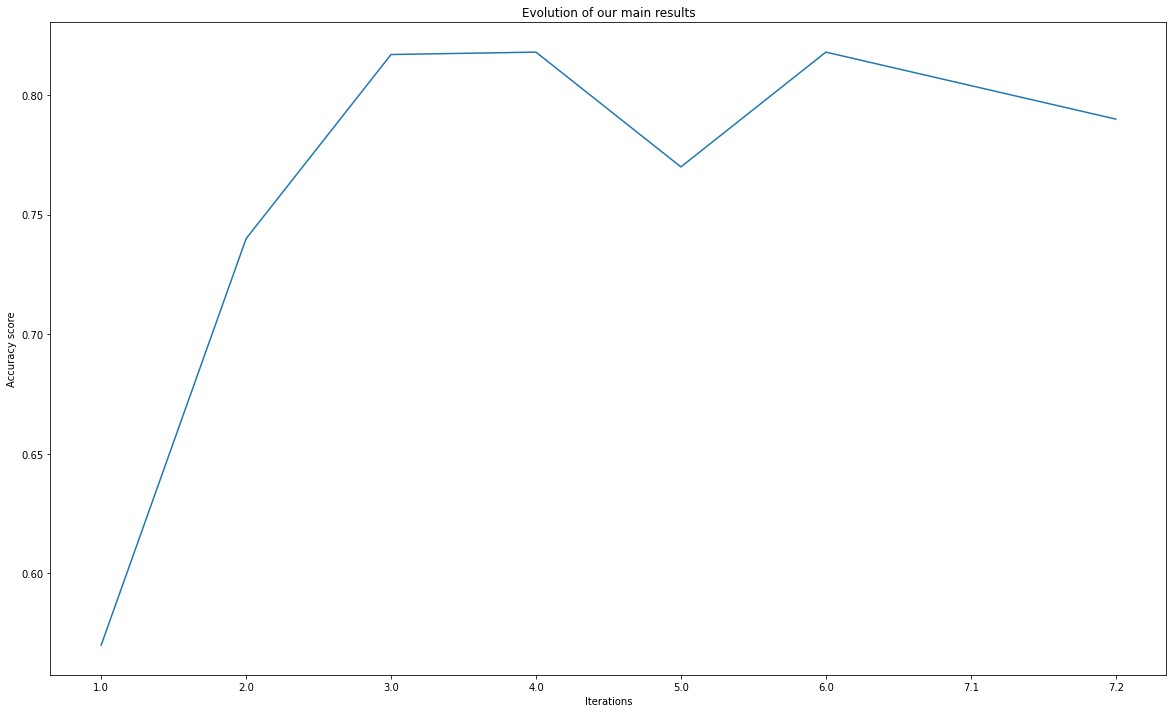

In [ ]:
import matplotlib as plt
progression = pd.read_csv('https://raw.githubusercontent.com/sfrancey/Real-or-Not-NLP-with-Disaster-Tweets_Team_Blancpain/main/Data/progression.csv',sep=";")
progression.x = progression.x.astype(str)
progression.plot(x="x",y="y",figsize=(20,12),title="Evolution of our main results", xlabel="Iterations",ylabel="Accuracy score", legend =False)

### Import and download some librairies

In [ ]:
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import seaborn as sns
%matplotlib inline
sns.set()
# Standard libraries
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import datasets
from sklearn.utils.multiclass import unique_labels
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import gensim.downloader
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import spacy
from gensim.models import Word2Vec

!pip install autocorrect
from autocorrect import Speller
spell = Speller(lang='en')

!pip install emot
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 624kB 5.8MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.2.2-cp36-none-any.whl size=621492 sha256=2deefd16e460035b7eb269ede7cffe6d1870ad394737b35249bca7fef6d8e37f
  Stored in directory: /root/.cache/pip/wheels/b4/0b/7d/98268d64c8697425f712c897265394486542141bbe4de319d6
Successfully built autocorrect


# Iteration 1 - Find the Base Rate

## Exploratory Data Analysis 🔎

### Load Data

Files
*   The training set - train.csv
*   The test set - test.csv
*   A sample submission file in the correct format - sample_submission.csv



In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/sfrancey/Real-or-Not-NLP-with-Disaster-Tweets_Team_Blancpain/main/Data/training_data.csv')

df_test = pd.read_csv('https://raw.githubusercontent.com/sfrancey/Real-or-Not-NLP-with-Disaster-Tweets_Team_Blancpain/main/Data/test_data.csv')

df_sample = pd.read_csv('https://raw.githubusercontent.com/sfrancey/Real-or-Not-NLP-with-Disaster-Tweets_Team_Blancpain/main/Data/sample_submission.csv')

### Visualization Trainset / Testset

**Features**: 

*   ID
*   Keyword - it describe the purpose of the related Tweet
*   Location - the place from where the Tweet has been published 
*   Text - the corp of the Tweet  
*   Target - equal to 1 if the Tweet talks about a real natural disasters or 0 if it's not. 





In [ ]:
df_train

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


In [ ]:
df_test

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
...,...,...,...,...
1137,3497,derailed,NaN,@ItsQueenBaby I'm at work it's a bunch of ppl ...
1138,9191,suicide%20bomber,NaN,#?? #?? #??? #??? Suicide bomber kills 15 in S...
1139,10217,volcano,NaN,Eruption of Indonesian volcano sparks transpor...
1140,5308,fear,New York,Never let fear get in the way of achieving you...


The training set is composed by: 6'471 rows and 5 features

The Test set is composed by: 1'142 rows and 4 features (target has been removed) 

**Remarks**: Both sets are pretty small. We can already make some asumptions about which modeling thechnique might work better than others (from the most accurate one to the less one): Logistic regression, KnN, Random Forest, Decision Trees.

### Missing values

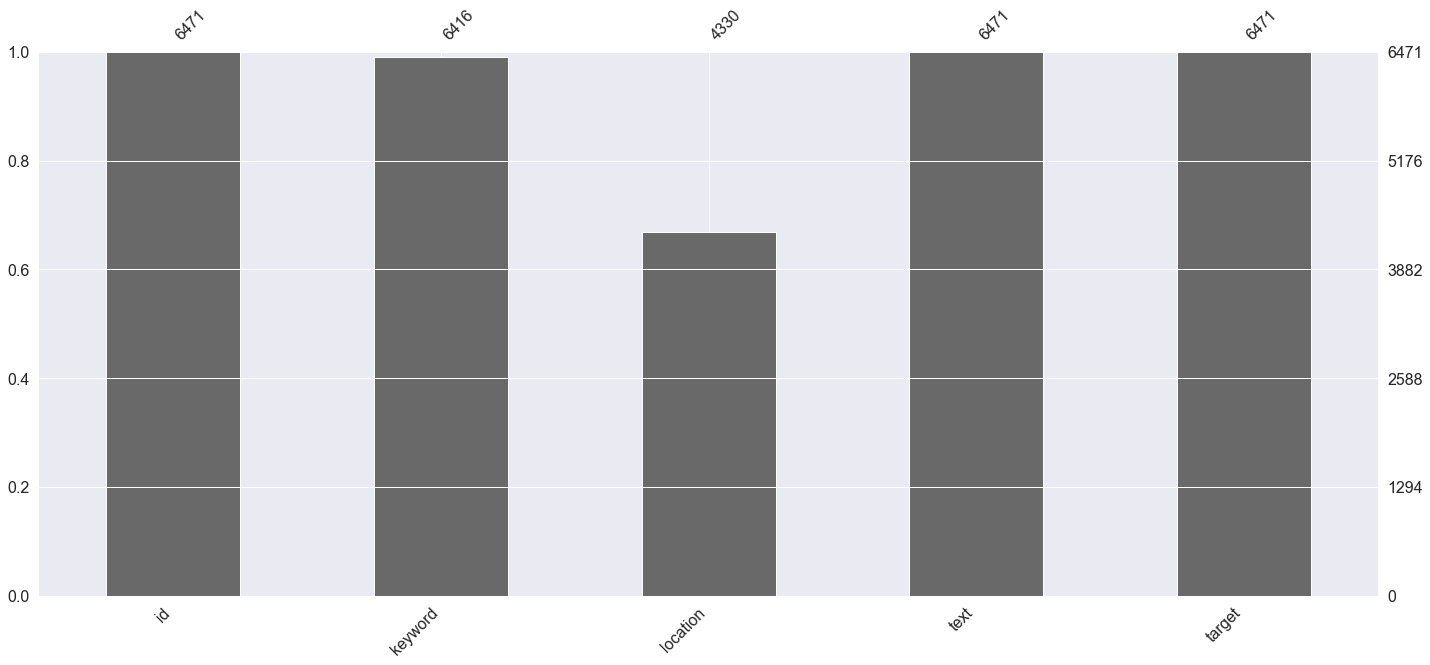

In [ ]:
import missingno as msno
msno.bar(df_train)

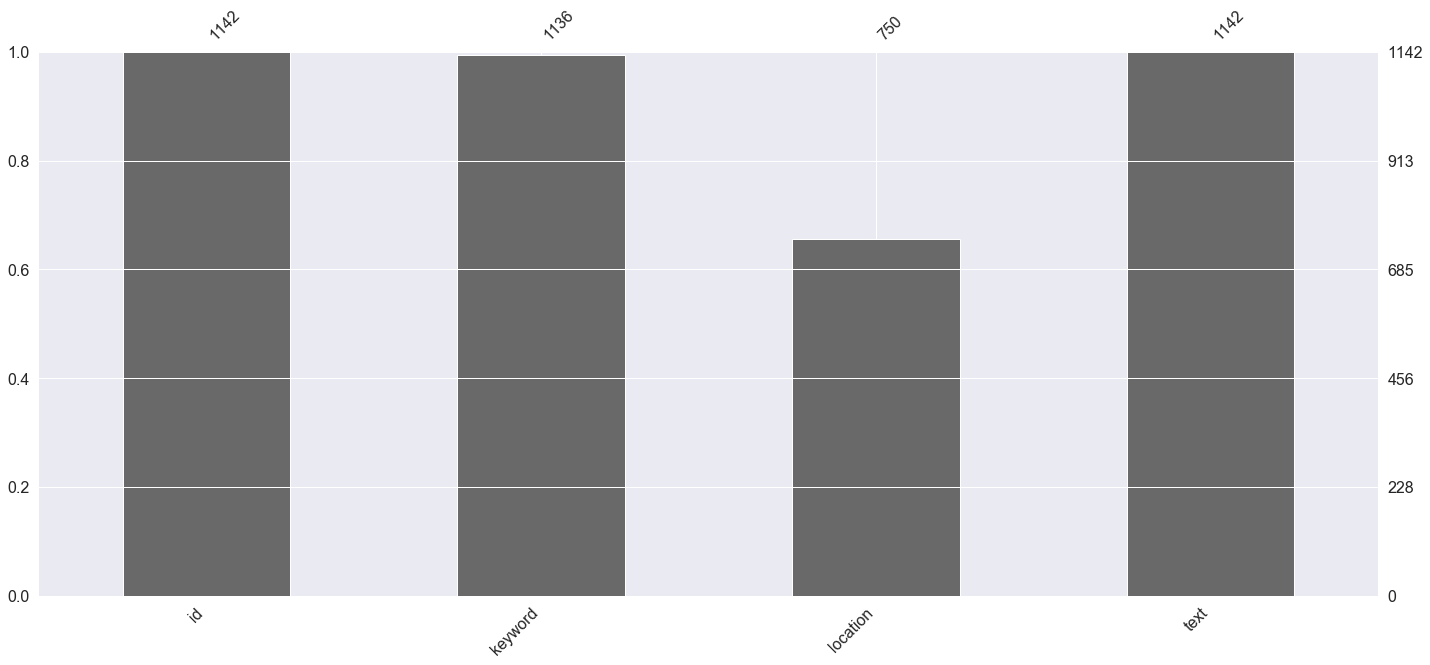

In [ ]:
msno.bar(df_test)

**Remark** :

Both sets have missing values for two features: Location and Keyword. 

The two plots show the same ratio of missing values for the Location feature which is around 66% of existing values in the train and the test sets. 

The keyword feature have a smaller portion of missing values. This small portion of missing values in the Keyword feature is not significant and we are going to use them for our first iteration.

The missing values will be replaced by a random token for the rest of the notebook.

In [ ]:
# Tokenize None values with an non-existing word to avoid confusion 
df_train.fillna("hfbghdugbdue", inplace = True)
df_test.fillna("hfbghdugbdue", inplace = True)

### Target visualization

In [ ]:
realDisaster = df_train[df_train['target'] == 1].shape[0]
notRealDisaster = df_train[df_train['target'] == 0].shape[0]

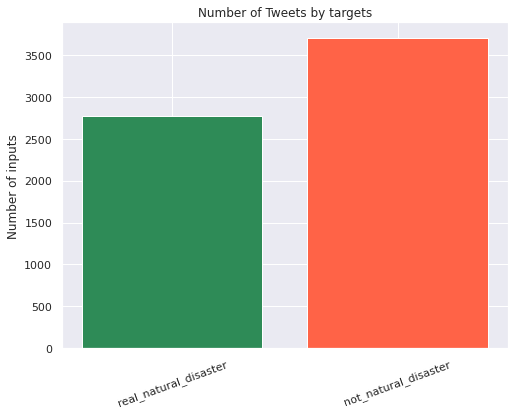

In [ ]:
#Plot the resulta
plt.rcParams['figure.figsize'] = (8, 6)
x = np.arange(2)
plt.bar(x,[realDisaster, notRealDisaster], color=['seagreen','tomato'])
plt.ylabel('Number of inputs')
plt.title('Number of Tweets by targets')
plt.xticks(x, ('real_natural_disaster', 'not_natural_disaster'), rotation=20)
plt.show()

**Remarks**:

We can extract directly the base rate from this plot and have a good idea of its quality

## The Base rate of the problem 

In [ ]:
base_rate = max(len(df_train[df_train["target"] == 0]) / len(df_train), len(df_train[df_train["target"] == 1]) / len(df_train))
print("The base rate Acc is :", base_rate)

The base rate Acc is : 0.5719363313243703


# Iteration 2 - Working on keywords

The focus is on Keywords. We're testing accuracies using an exemple of basic model (kNN) with few pre-processing. 

## EDA keyword feature 🔎

In [ ]:
# Clean keyword feature by regrouping some equal meaning keywords
def replace_words(df, col_name):
  df[col_name] = df[col_name].replace(["suicide%20bomber","suicide%20bombing","suicide%20bomb"],"suicide%20bombing")
  df[col_name] = df[col_name].replace(["building%20fires","buildings%20burning","buildings%20on%20fire","burning%20buildings"],"building%20fires")
  df[col_name] = df[col_name].replace(["bush%20fires","forest%20fires","wild%20fires","hellfire","forest%20fire"],"natural%20fires")
  df[col_name] = df[col_name].replace(["blew%20up","blown%20up"],"blew%20up")
  df[col_name] = df[col_name].replace(["body%20bags","body%20bagging","body%20bag"],"body%20bags")
  df[col_name] = df[col_name].replace(["nuclear%20reactor","nuclear%20disaster"],"nuclear")
  return df

In [ ]:
# Cleaning Keywords on train set
df_train_cleaned = replace_words(df_train, 'keyword')
df_train_cleaned = replace_words(df_train, 'text')

# Cleaning Keywords on test set
df_test_cleaned = replace_words(df_test, 'keyword')
df_test_cleaned = replace_words(df_test, 'text')

In [ ]:
df_train_cleaned['keyword'].nunique()

210

In [ ]:
# Top 15 Keywords related to real natural disasters

keywordRealTop = df_train_cleaned['keyword'].loc[(df_train_cleaned['target'] == 1)].value_counts()[0:15]

# Top 15 Keywords related to not real natural disasters

keywordNotRealTop = df_train_cleaned['keyword'].loc[(df_train_cleaned['target'] == 0)].value_counts()[0:15]

**Remarks**:

This will allow to identify which keywords are most related with a real disaster and which one are for a non-real disaster.

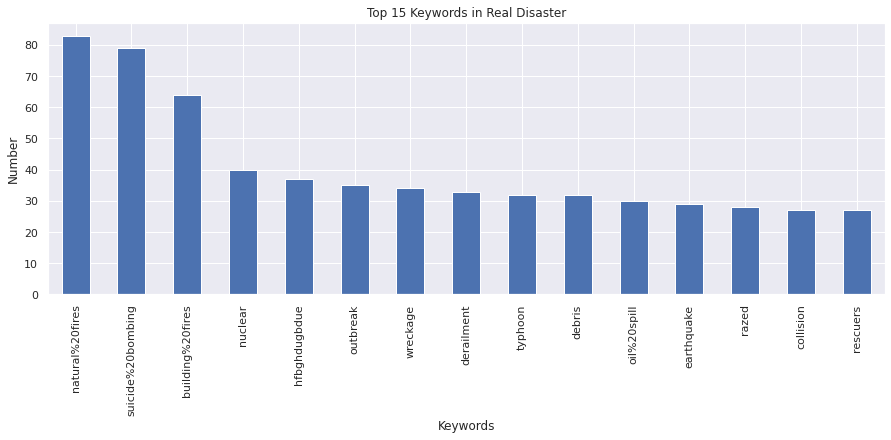

In [ ]:
#Plot top 15 real
keywordRealTop.plot.bar(xlabel = 'Keywords', 
                          ylabel = 'Number', 
                          title = 'Top 15 Keywords in Real Disaster', 
                          figsize=(15, 5), 
                          #color = 'lightgoldenrodyellow',
                        )

**Remarks**: 
We can already see that some keywords are related to natural disasters even if they're obviously refairing to something made by a human (eg. top 2 "suicide Bombing"). Keywords need to be filtred to be useful. 

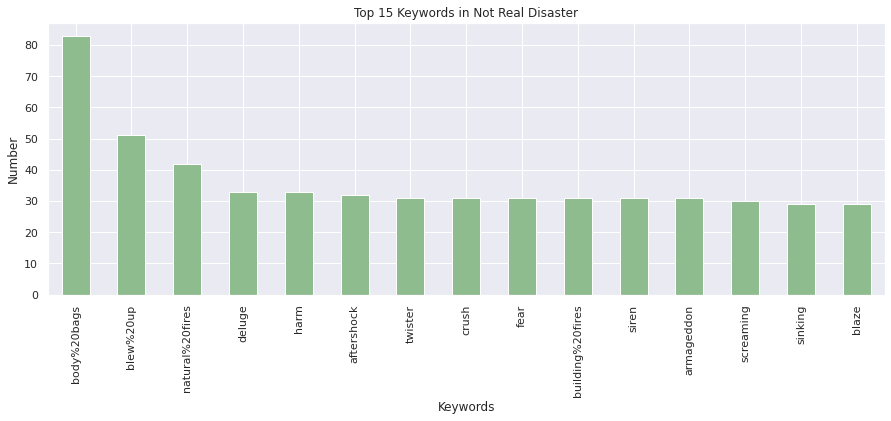

In [ ]:
#Plot top 15 not real
keywordNotRealTop.plot.bar(xlabel = 'Keywords', 
                          ylabel = 'Number', 
                          title = 'Top 15 Keywords in Not Real Disaster',
                          figsize=(15, 5), 
                          color = 'darkseagreen')

**Remarks**: 
Same consideration as for natural disasters. Some keywords are correlated with target 0 even if they are related to a natural disaster (eg. "natural fire". 

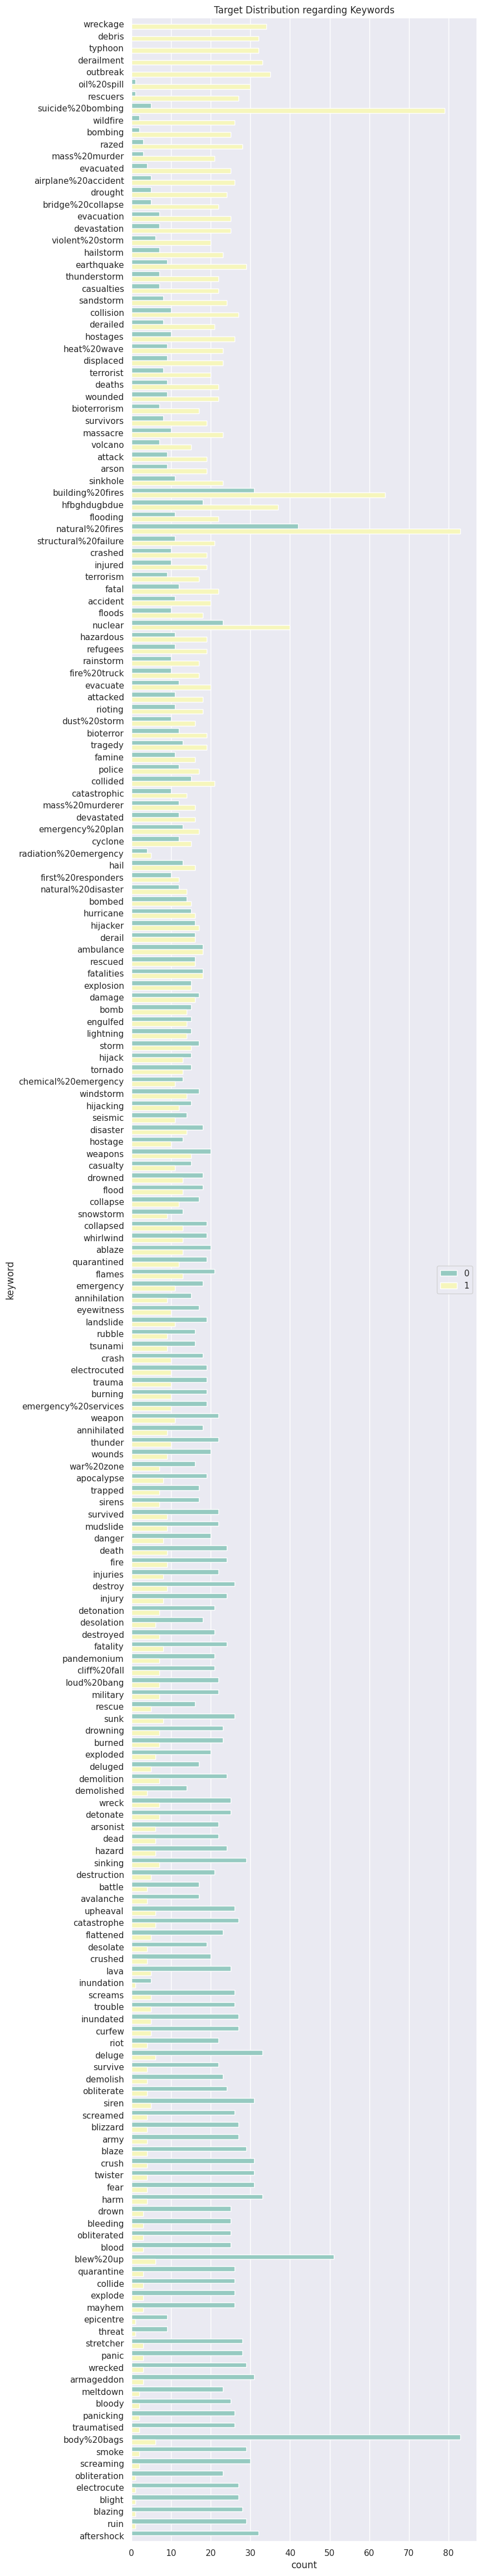

In [ ]:
#Identify how Keywords are related to each target and which ones are ambigous through them.

df_train_cleaned['targetM'] = df_train_cleaned.groupby('keyword')['target'].transform('mean')

figKey = plt.figure(figsize=(8, 60), dpi=100)

sns.countplot(y=df_train_cleaned.sort_values(by='targetM', ascending=False)['keyword'],
              hue=df_train_cleaned.sort_values(by='targetM', ascending=False)['target'],palette="Set3")

plt.legend()
plt.title('Target Distribution regarding Keywords')

plt.show()

**Remarks**:

If we dig deeper in the relation of keywords with the target value, some of those keywords seem to be highly correlated with one specific target value. Others could not have any statistic reliance to one of the target value and might be droped later even if they have been identified as top 15 for each target type (eg. even if "natural fire" is linked with more tweets for natural disaster, half of the count is alsi linked with not natural disaster). 

**Conclusion**: We only should consider Keywords that are around 90% of times related to a specific target (to be tested in further iterations). 

## Tokenization

In [ ]:
# Load English language model
sp = spacy.load('en_core_web_sm')

def tokenize_function(text):
    # Create token object, which is used to create documents with linguistic annotations.
    sp_obj = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in sp_obj ]
    
    return mytokens

## Modelling

A simple model is used to make some assumptions on Keywords and their relevance.  

**Remark:** the kNN model is used to illustrate our pipeline. We have tried it using other models. 

**Remark 2:** we splited our train set into a smaller train + a test one called "evaluation" in order to get our accuracies on the test set.  

In [ ]:
def eval_pipeline_basic(df_train, df_test, tokenize_fct, name, target_col='keyword', model_type='knn', feature_engineering='tfidf'):
  ''' Eval pipeline '''

  # Make copies to avoid any changes in the main datasets
  train = df_train.copy()
  test = df_test.copy()

  if model_type == 'knn':
    model = KNeighborsClassifier(n_jobs=multiprocessing.cpu_count())

  # -------------------------------------- Define embeddings --------------------------------------
  if feature_engineering == 'tfidf':
    model = Pipeline([('tfidf', TfidfVectorizer(tokenizer=tokenize_fct)),
                      ('clf', model)])
  
  elif feature_engineering == 'w2v':

    # Function that uses w2v embeddings and compute the mean value of all the of w2v vectors of all the words
    def document_vector(doc):
      """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
      tokens = tokenize_fct(doc)
      doc = [word for word in tokens if word in feature_vector.wv.vocab]
      return np.mean(feature_vector[doc], axis=0)

    # Create corpus for w2v
    sentences = []
    for text in [list(train[target_col]), list(test[target_col])]:
      for string in text:
        sentences.append(tokenize_fct(string))

    # Create w2v embeddings
    feature_vector = gensim.models.Word2Vec(sentences, 
                                            size=100, 
                                            window=10, 
                                            min_count=1, 
                                            iter=20,
                                            seed=50,
                                            workers=multiprocessing.cpu_count()
                                            )

    train[target_col] = train[target_col].apply(document_vector)
    test[target_col] = test[target_col].apply(document_vector)
  
  # -------------------------------------- Split dataset --------------------------------------
  df_train_eval, df_validation = train_test_split(train, test_size=0.2, random_state = 50)

  y_train_eval = df_train_eval[["target"]]
  y_validation = df_validation[["target"]]

  X1_train_eval = list(df_train_eval[target_col])
  X1_validation = list(df_validation[target_col])

  # -------------------------------------- Fit data --------------------------------------
  
  model.fit(X1_train_eval, y_train_eval)

  # -------------------------------------- Eval data --------------------------------------
  train_accuracy_score = accuracy_score(y_train_eval, model.predict(X1_train_eval))
  print(f"The training accuracy is : {train_accuracy_score}")

  validation_accuracy_score = accuracy_score(y_validation, model.predict(X1_validation))
  print(f"The validation accuracy is : {validation_accuracy_score}")

  # -------------------------------------- Retrain on the full dataset --------------------------------------
  y_train = train[["target"]]
  X1_train = list(train[target_col])
  X1_test = list(test[target_col])

  # Create submission file
  model.fit(X1_train, y_train)

  submission = pd.DataFrame(model.predict(X1_test), columns=["target"])
  submission.to_csv(f'submission_{target_col}_{feature_engineering}_model_{model_type}_{name}.csv', index=False)

In [ ]:
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'basic', target_col='keyword', model_type='knn', feature_engineering='tfidf')

The training accuracy is : 0.7109737248840804
The validation accuracy is : 0.6718146718146718


In [ ]:
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'basic', target_col='keyword', model_type='knn', feature_engineering='w2v')

The training accuracy is : 0.7129057187017002
The validation accuracy is : 0.6749034749034749


**Remarks**:

The model with tfidf is much stronger than the w2v embeddings. Hence we might drop it in the next tests

**Best accuracy score**: 


*   Logistic Regression - Keyword/Target - TFIDF : 0.74 (↗)

# Iteration 3 - Working on text 

## EDA text feature 🔎

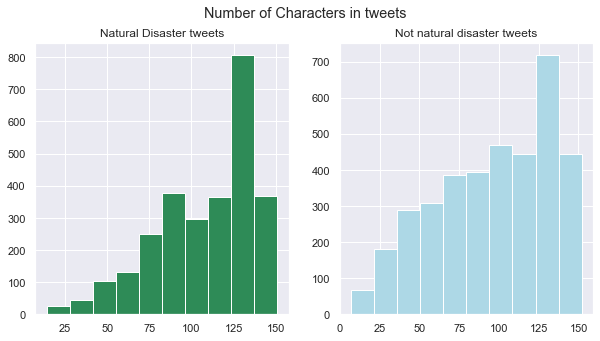

In [ ]:
#Number of characters in a Tweet 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

tweetRealTrain = df_train_cleaned[df_train_cleaned['target']==1]['text'].str.len()
ax1.hist(tweetRealTrain,color='seagreen')
ax1.set_title('Natural Disaster tweets')

tweetNotRealTrain = df_train_cleaned[df_train_cleaned['target']==0]['text'].str.len()
ax2.hist(tweetNotRealTrain,color='lightblue')
ax2.set_title('Not natural disaster tweets')
fig.suptitle('Number of Characters in tweets')
plt.show()

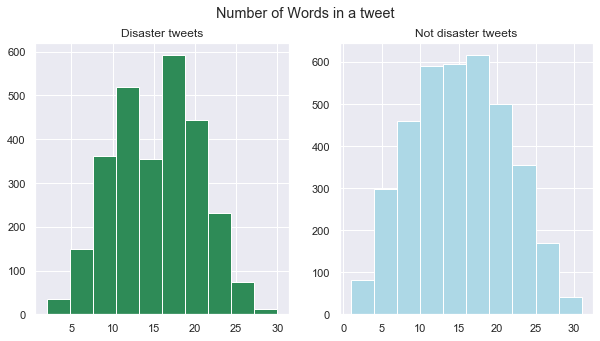

In [ ]:
#Number of words in a Tweet 
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweetReal = df_train_cleaned[df_train_cleaned['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweetReal,color='seagreen')
ax1.set_title('Disaster tweets')

tweetNotReal = df_train_cleaned[df_train_cleaned['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweetNotReal,color='lightblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Number of Words in a tweet')

plt.show()

**Remarks**:

The length of the tweet or the number of words do not seem to be useful as a feature for a model.

In [ ]:
#Find most common words on Tweets 
import nltk
from nltk import tokenize

tokenSpace = tokenize.WhitespaceTokenizer()

def counter_common_words(text, columnText, quantity, title):
    allWords = ' '.join([text for text in text[columnText]])
    tokenizedPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenizedPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="Set3")
    ax.set(ylabel = "Count")
    plt.title(title)
    plt.xticks(rotation='horizontal')
    plt.show()

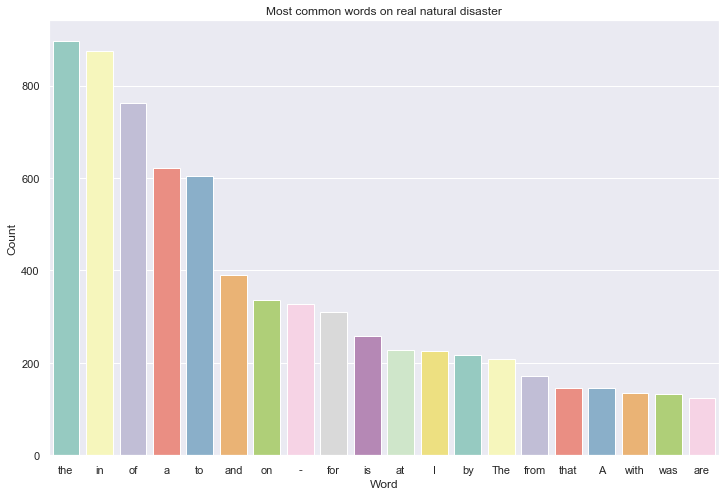

In [ ]:
counter_common_words(df_train_cleaned[df_train_cleaned['target'] == 1], 'text', 20, 'Most common words on real natural disaster')

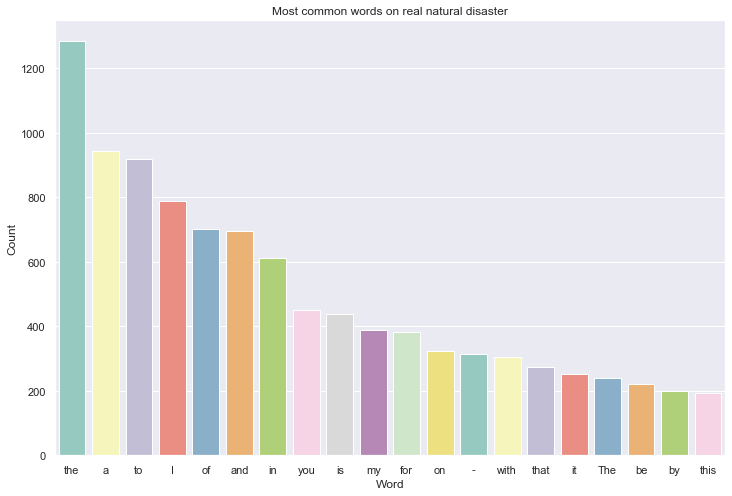

In [ ]:
counter_common_words(df_train_cleaned[df_train_cleaned['target'] == 0], 'text', 20, 'Most common words on real natural disaster')

**Remarks**:

Those words do not add any real information to a particular tweet and they quite appear a lot in the real world. They're mainly stopwords and puctuation marks. Hence removing them might reduce the noise within datasets.

## Tokenization

We develop the preprocessing part to see if removing stopwords and puctuation is helpful.

In [ ]:
# Load English language model
sp = spacy.load('en_core_web_sm')

## Create a list of punctuation marks
punctuations = string.punctuation

## Create a list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenize_function_stop_ponct(text):
    # Create token object, which is used to create documents with linguistic annotations.
    sp_obj = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in sp_obj ]

    # Remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words]

    # Remove punctuation
    mytokens = [ word for word in mytokens if word not in punctuations]
    
    return mytokens

## Modelling

A simple model is used to make some assumptions on texts and their relevance.

**Remark**: the kNN model is used to illustrate our pipeline. We have tried it using all other models.

In [ ]:
# same as the preivous one

In [ ]:
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'text_basic', target_col='text', model_type='knn', feature_engineering='tfidf')
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function_stop_ponct, 'text_stop_ponct', target_col='text', model_type='knn', feature_engineering='tfidf')

The training accuracy is : 0.8236089644513137
The validation accuracy is : 0.7768339768339768
The training accuracy is : 0.8280525502318392
The validation accuracy is : 0.7575289575289575


In [ ]:
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'text_basic', target_col='text', model_type='knn', feature_engineering='w2v')
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function_stop_ponct, 'text_stop_ponct', target_col='text', model_type='knn', feature_engineering='w2v')

The training accuracy is : 0.8004250386398764
The validation accuracy is : 0.7397683397683398
The training accuracy is : 0.803516228748068
The validation accuracy is : 0.7343629343629343


**Remarks**:

The remove of the stopwords did not change the quality of the predictions strangely! Worst it decreased of approx. 0.02 points the quality on Tfidf. We should keep them for our further iterations. On the other hand, we can see that the text is a better feature than keyword.

**Best accuracy score**:

Logistic Regression - text (with stopwords and punctuation) - TFIDF : 0.817 (↗)

# Iteration 4 - Working on Keywords + Text 

## Further EDA of the keyword plus the text 🔎

As shown on the previous EDA over the keywords (iteration 2), some of them are highly correlated to only one specific target value and some are more ambigous! Hence we define an heuristic to select keywords that are represented more than 87% of the time in only one of the target value.

(6471, 6)
(1520, 6)


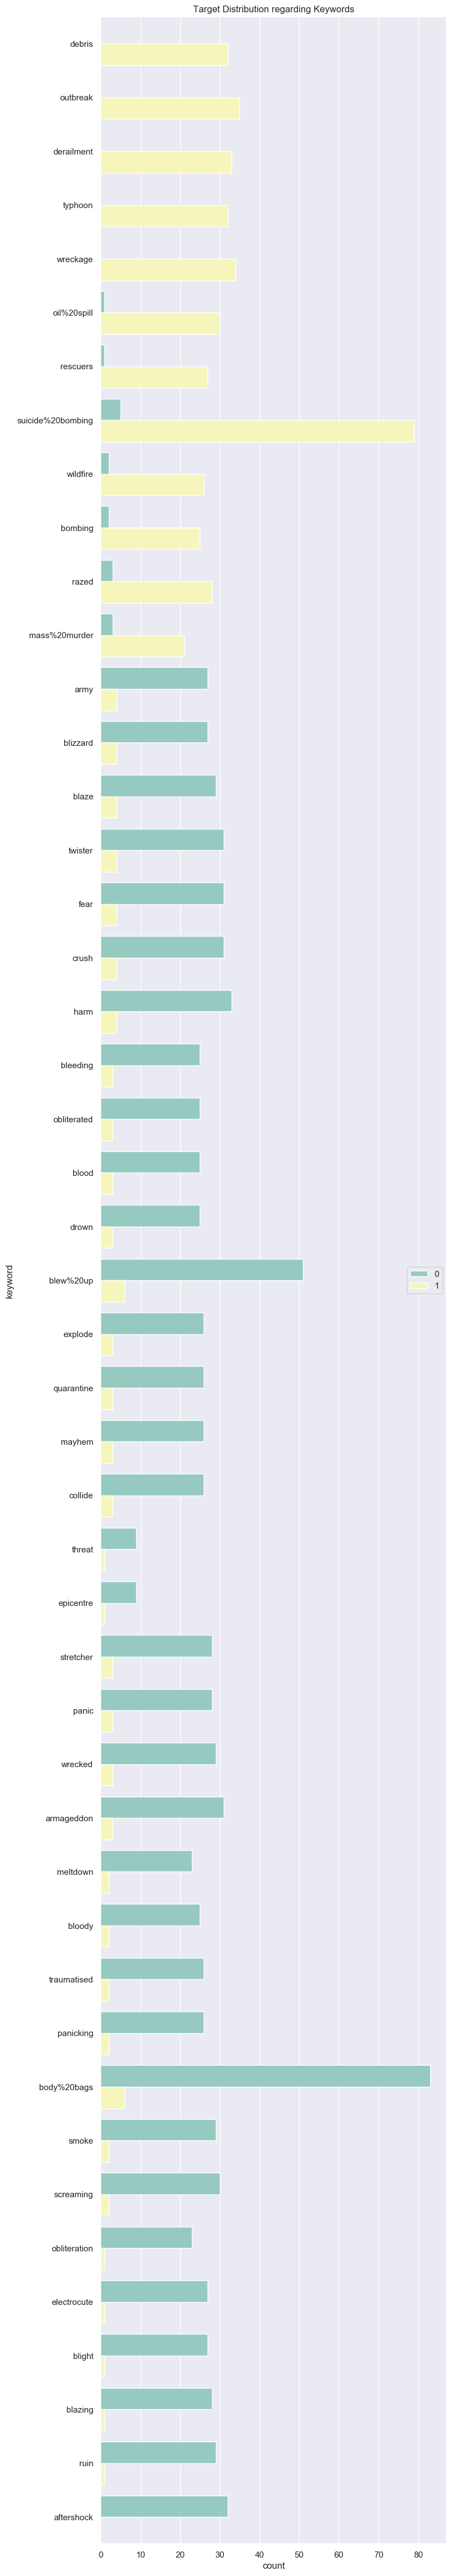

In [ ]:
df_train_cleaned['targetM'] = df_train_cleaned.groupby('keyword')['target'].transform('mean')
print(df_train_cleaned.shape)
df_train_selected = df_train_cleaned[(df_train_cleaned['targetM'] > 0.87) | (df_train_cleaned['targetM'] < 0.13)]
print(df_train_selected.shape)

figKey = plt.figure(figsize=(8, 60), dpi=100)

sns.countplot(y=df_train_selected.sort_values(by='targetM', ascending=False)['keyword'],
              hue=df_train_selected.sort_values(by='targetM', ascending=False)['target'],palette="Set3")

plt.legend()
plt.title('Target Distribution regarding Keywords')

plt.show()

In [ ]:
# Creating a list of most relevant keywords
keywords_list = df_train_selected['keyword'].unique()
keywords_list

array(['panicking', 'suicide%20bombing', 'body%20bags', 'blight',
       'armageddon', 'stretcher', 'razed', 'ruin', 'fear', 'wreckage',
       'derailment', 'obliterated', 'bombing', 'army', 'blood', 'panic',
       'obliteration', 'blazing', 'typhoon', 'outbreak', 'wrecked',
       'oil%20spill', 'mayhem', 'epicentre', 'rescuers', 'drown',
       'quarantine', 'debris', 'twister', 'wildfire', 'aftershock',
       'blizzard', 'explode', 'bleeding', 'meltdown', 'bloody', 'crush',
       'traumatised', 'electrocute', 'harm', 'smoke', 'screaming',
       'mass%20murder', 'blew%20up', 'blaze', 'collide', 'threat'],
      dtype=object)

In [ ]:
# New dataframes merging keywords and texts 

df_train_cleaned["keyword_text"] = df_train_cleaned['keyword'] + ' ' + df_train_cleaned['text'] 
df_train_cleaned["keyword_text"] = df_train_cleaned["keyword_text"].astype(str)
df_test_cleaned["keyword_text"] = df_test_cleaned['keyword'] + ' ' + df_test_cleaned['text'] 
df_test_cleaned["keyword_text"] = df_test_cleaned["keyword_text"].astype(str)

def clean_keword_text(row):
  if row['keyword'] in keywords_list:
    return row['keyword'] + ' ' + row['text']
  else:
    return row['text']

df_train_cleaned["keyword_cleaned_text"] = df_train_cleaned.apply(clean_keword_text, axis=1)
df_test_cleaned["keyword_cleaned_text"] = df_test_cleaned.apply(clean_keword_text, axis=1)

## Tokenization

In [ ]:
# Same as before

## Modelling

A simple model is used to make some assumptions on texts and keywords (regular or selected) merged and their relevance.

**Remark**: the kNN model is used to illustrate our pipeline. We have tried it using other models.

In [ ]:
# Same as before
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'basic', target_col='keyword_text', model_type='knn', feature_engineering='tfidf')
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'basic', target_col='keyword_cleaned_text', model_type='knn', feature_engineering='tfidf')

The training accuracy is : 0.8222565687789799
The validation accuracy is : 0.7505791505791506
The training accuracy is : 0.8247681607418856
The validation accuracy is : 0.7760617760617761


**Remarks**:

By cleaning the keywords and using only the most significant ones, we are able to improve the model performance by 4 percent on kNN model.

**Best accuracy score**:

Logistic Regression - text (with stopwords and punctuation) + Selected Keywords - TFIDF : 0.818 (↗)

# Iteration 5 - Working on Location

## EDA on the Location feature 🔎

Make some cleaning on Location feature to normalize the spelling and to regroup similar ones. The methode used is the same as the one for iteration 4 on Keywords. 

Exemple of regroupments: 
```
df[col_name] = df[col_name].replace(["London","London, England","London, UK","london"],"London, UK")
```





In [ ]:
def replace_words(df, col_name):
    # Cleaning from keywords
    
    df[col_name] = df[col_name].replace(["suicide%20bomber","suicide%20bombing","suicide%20bomb"],"suicide%20bombing")
    df[col_name] = df[col_name].replace(["building%20fires","buildings%20burning","buildings%20on%20fire","burning%20buildings"],"building%20fires")
    df[col_name] = df[col_name].replace(["bush%20fires","forest%20fires","wild%20fires","hellfire","forest%20fire"],"natural%20fires")
    df[col_name] = df[col_name].replace(["blew%20up","blown%20up"],"blew%20up")
    df[col_name] = df[col_name].replace(["body%20bags","body%20bagging","body%20bag"],"body%20bags")
    df[col_name] = df[col_name].replace(["nuclear%20reactor","nuclear%20disaster"],"nuclear")
    
    # Cleaning from locations 

    df[col_name] = df[col_name].replace(["Adelaide, Australia"],"Adelaide, AU")
    df[col_name] = df[col_name].replace(["Alaska"],"AK, USA")
    df[col_name] = df[col_name].replace(["Ashburn, VA"],"Ashburn, VA, USA")
    df[col_name] = df[col_name].replace(["Atlanta, GA","Atlanta", "Atlanta Georgia"],"Atlanta, GA, USA")
    df[col_name] = df[col_name].replace(["Austin, TX"],"Austin, TX, USA")
    df[col_name] = df[col_name].replace(["Bakersfield, California"],"Bakersfield, CA, USA")
    df[col_name] = df[col_name].replace(["Barbados"],"BB")
    df[col_name] = df[col_name].replace(["Bend, Oregon"],"Bend, OR, USA")
    df[col_name] = df[col_name].replace(["Berlin - Germany"],"Berlin, GER")
    df[col_name] = df[col_name].replace(["Birmingham"],"Birmingham, UK")
    df[col_name] = df[col_name].replace(["ÌÏT: 10.614817868480726,12.195582811791382"],"Biu, NG")
    df[col_name] = df[col_name].replace(["Boise, Idaho"],"Boise, ID, USA")
    df[col_name] = df[col_name].replace(["Boston, MA"],"Boston, MA, USA")
    df[col_name] = df[col_name].replace(["Brazil"],"Brazil, BA")
    df[col_name] = df[col_name].replace(["British Columbia, Canada"],"British_Columbia, CAN")
    df[col_name] = df[col_name].replace(["Brooklyn, NY"],"Brooklyn, NY, USA")
    df[col_name] = df[col_name].replace(["Budapest, Hungary"],"Budapest, HUN")
    df[col_name] = df[col_name].replace(["Bukittinggi  ?? Sumatera Barat"],"Bukittinggi, INA")
    df[col_name] = df[col_name].replace(["Canada"],"Canada, CAN")
    df[col_name] = df[col_name].replace(["California", "California, USA", "California, United States"],"CA, USA")
    df[col_name] = df[col_name].replace(["Calcary, AB, Canada", "Calgary", 'Calgary, Alberta', 'Calgary, AB, Canada'],"Calcary, CAN")
    df[col_name] = df[col_name].replace(["Cape Town"],"Cape Town, SA")
    df[col_name] = df[col_name].replace(["Charlotte, NC"],"Charlotte, NC, USA")
    df[col_name] = df[col_name].replace(["Chicago, IL, USA", 'Chicago'],"Chicago, IL, USA")
    df[col_name] = df[col_name].replace(["china", 'China'],"China, CN")
    df[col_name] = df[col_name].replace(["Colorado"],"CO, USA")
    df[col_name] = df[col_name].replace(["Coventry"],"Coventry, UK")
    df[col_name] = df[col_name].replace(["Dallas, TX", 'Street of Dallas'],"Dallas, TX, USA")
    df[col_name] = df[col_name].replace(["Decatur, GA"],"Decatur, GA, USA")
    df[col_name] = df[col_name].replace(["Cherry Creek Denver CO", 'Denver, Colorado', 'Denver, CO'],"Denver, CO, USA")
    df[col_name] = df[col_name].replace(["Derby"],"Derby, UK")
    df[col_name] = df[col_name].replace(["DOMINICANA REPUBLICA"],"Dominican Republic, DO")
    df[col_name] = df[col_name].replace(["Edinburgh"],"Edinburgh, UK")
    df[col_name] = df[col_name].replace(["El Dorado, Arkansas"],"El Dorado, AR, USA")
    df[col_name] = df[col_name].replace(["Erie, PA"],"Erie, PA, USA")
    df[col_name] = df[col_name].replace(["Florida"],"FL, USA")
    df[col_name] = df[col_name].replace(["Geneva"],"Geneva, CH")
    df[col_name] = df[col_name].replace(["Germany"],"Germany, GER")
    df[col_name] = df[col_name].replace(["Glasgow"],"Glasgow, UK")
    df[col_name] = df[col_name].replace(["Haddonfield, NJ"],"Haddonfield, NJ, USA")
    df[col_name] = df[col_name].replace(["Hawaii, USA","Ewa Beach, HI"],"Hawaii, HI, USA")
    df[col_name] = df[col_name].replace(["Hong Kong"],"Hong Kong, CN")
    df[col_name] = df[col_name].replace(["Houston, TX","Houston TX"],"Houston, TX, USA")
    df[col_name] = df[col_name].replace(["Ireland"],"Ireland, IE")
    df[col_name] = df[col_name].replace(["Indiana"],"IN, USA")
    df[col_name] = df[col_name].replace(["India"],"India, IND")
    df[col_name] = df[col_name].replace(["Indonesia"],"Indonesia, INA")
    df[col_name] = df[col_name].replace(["Inexpressible Island"],"Inexpressible Island, ANT")
    df[col_name] = df[col_name].replace(["Italy"],"Italy, IT")
    df[col_name] = df[col_name].replace(["Kansas City"],"Kansas City, MO, USA")
    df[col_name] = df[col_name].replace(["Karachi, Pakistan","Karachi"],"Karachi, PK")
    df[col_name] = df[col_name].replace(["Kashmir!"],"Kashmir, IND")
    df[col_name] = df[col_name].replace(["Kenya"],"Kenya, KY")
    df[col_name] = df[col_name].replace(["Kingston, Jamaica"],"Kingston, JAM")
    df[col_name] = df[col_name].replace(["Korea"],"Korea, KR")
    df[col_name] = df[col_name].replace(["Louisiana"],"LA, USA")
    df[col_name] = df[col_name].replace(["Lagos, Nigeria","Lagos"],"Lagos, NG")
    df[col_name] = df[col_name].replace(["Leeds, England"],"Leeds, UK")
    df[col_name] = df[col_name].replace(["London","London, England","London, UK","london"],"London, UK")
    df[col_name] = df[col_name].replace(["Los Angeles","Los Angeles, CA","Subconscious LA"],"Los Angeles, CA, USA")
    df[col_name] = df[col_name].replace(["Massachusetts"],"MA, USA")
    df[col_name] = df[col_name].replace(["Manchester, NH"],"Manchester, NH, USA")
    df[col_name] = df[col_name].replace(["Manchester","Manchester, England"],"Manchester, UK")
    df[col_name] = df[col_name].replace(["Maryland"],"MD, USA")
    df[col_name] = df[col_name].replace(["Melbourne","Melbourne, Australia"],"Melbourne, AU")
    df[col_name] = df[col_name].replace(["Memphis, TN"],"Memphis, TN, USA")
    df[col_name] = df[col_name].replace(["19.600858, -99.047821"],"Mexico City, MX")
    df[col_name] = df[col_name].replace(["Michigan"],"MI, USA")
    df[col_name] = df[col_name].replace(["Miami, FL"],"Miami, FL, USA")
    df[col_name] = df[col_name].replace(["swmo"],"MO, USA")
    df[col_name] = df[col_name].replace(["Morioh, Japan"],"Morioh, JP")
    df[col_name] = df[col_name].replace(["Mumbai"],"Mumbai, IND")
    df[col_name] = df[col_name].replace(["Muntinlupa City, Philippines"],"Muntinlupa City, PH")
    df[col_name] = df[col_name].replace(["Nairobi"],"Nairobi, KY")
    df[col_name] = df[col_name].replace(["Nashville, TN"],"Nashville, TN, USA")
    df[col_name] = df[col_name].replace(["North Carolina","North Carolina, USA","NC"],"NC, USA")
    df[col_name] = df[col_name].replace(["New Delhi, India"],"New Delhi, IND")
    df[col_name] = df[col_name].replace(["New Hanover County, NC"],"New Hanover County, NC, USA ")
    df[col_name] = df[col_name].replace(["New Jersey"],"NJ, USA")
    df[col_name] = df[col_name].replace(["New Orleans, LA"],"New Orleans, LA, USA")
    df[col_name] = df[col_name].replace(["New York","NYC","New York City","New York, NY","New York, USA"],"New York, NY, USA")
    df[col_name] = df[col_name].replace(["Newark, NJ"],"Newark, NJ, USA")
    df[col_name] = df[col_name].replace(["New Hampshire"],"NH, USA")
    df[col_name] = df[col_name].replace(["Nigeria"],"Nigeria, NG")
    df[col_name] = df[col_name].replace(["NJ"],"NJ, USA")
    df[col_name] = df[col_name].replace(["107-18 79TH STREET"],"NY, USA")
    df[col_name] = df[col_name].replace(["Oakland, CA"],"Oakland, CA, USA")
    df[col_name] = df[col_name].replace(["Oklahoma City, OK","Oklahoma City"],"Oklahoma City, OK, USA")
    df[col_name] = df[col_name].replace(["Oregon","Oregon, USA"],"OR, USA")
    df[col_name] = df[col_name].replace(["Orlando, FL"],"Orlando, FL, USA")
    df[col_name] = df[col_name].replace(["Paterson, New Jersey"],"Paterson, NJ, USA")
    df[col_name] = df[col_name].replace(["Pennsylvania, USA"],"Pennsylvania, PA, USA")
    df[col_name] = df[col_name].replace(["Phoenix, AZ"],"Phoenix, AZ, USA")
    df[col_name] = df[col_name].replace(["Portland, Oregon"],"Portland, OR, USA")
    df[col_name] = df[col_name].replace(["Raleigh, NC"],"Raleigh, NC, USA")
    df[col_name] = df[col_name].replace(["Pakistan"],"PK")
    df[col_name] = df[col_name].replace(["Redding, California, USA"],"Redding, CA, USA")
    df[col_name] = df[col_name].replace(["Renfrew, Scotland"],"Renfrew, UK")
    df[col_name] = df[col_name].replace(["Rio de Janeiro"],"Rio de Janeiro, BR")
    df[col_name] = df[col_name].replace(["Sacramento, CA","Sacramento"],"Sacramento, CA, USA")
    df[col_name] = df[col_name].replace(["San Diego, CA"],"San Diego, CA, USA")
    df[col_name] = df[col_name].replace(["San Francisco","San Francisco, CA","San Francisco Bay Area"],"San Francisco, CA, USA")
    df[col_name] = df[col_name].replace(["Seattle, WA","Seattle","Seattle, Washington"],"Seattle, WA, USA")
    df[col_name] = df[col_name].replace(["Singapore"],"Singapore, SG	Singapore")
    df[col_name] = df[col_name].replace(["St Paul, MN"],"St Paul, MN, USA")
    df[col_name] = df[col_name].replace(["State College, PA"],"State College, PA, USA")
    df[col_name] = df[col_name].replace(["Stockholm, Sweden"],"Stockholm, SWE")
    df[col_name] = df[col_name].replace(["Sweden"],"SWE")
    df[col_name] = df[col_name].replace(["Sydney, Australia","Sydney"],"Sydney, AU")
    df[col_name] = df[col_name].replace(["The Netherlands"],"NL")
    df[col_name] = df[col_name].replace(["Tennessee"],"TN, USA")
    df[col_name] = df[col_name].replace(["Tokyo"],"Tokyo, JP")
    df[col_name] = df[col_name].replace(["Toronto","Toronto, Ontario"],"Toronto, CA")
    df[col_name] = df[col_name].replace(["Texas","Republic of Texas"],"TX, USA")
    df[col_name] = df[col_name].replace(["United Kingdom","#FLIGHTCITY UK"],"UK")
    df[col_name] = df[col_name].replace(["United States","United States, USA","US","South, USA","Cleveland, OH - San Diego, CA","USA (Formerly @usNOAAgov)"],"USA")
    df[col_name] = df[col_name].replace(["In the potters hands","Jupiter","Heaven","?????","Breaking News","??","???  Dreamz","Instagram - @heyimginog","Somewhere Only We Know ?","Gotham City","South Stand","?????","???"],"unknown")
    df[col_name] = df[col_name].replace(["Virginia"],"VA, USA")
    df[col_name] = df[col_name].replace(["Victoria, Australia, Earth"],"Victoria, AUS")
    df[col_name] = df[col_name].replace(["Victoria, BC"],"Victoria, CAN")
    df[col_name] = df[col_name].replace(["Washington","Washington DC","Washington D.C.","Washington, D.C","Washington, DC"],"Washington DC, USA")
    df[col_name] = df[col_name].replace(["Wisconsin"],"WI, USA")
    df[col_name] = df[col_name].replace(["Earth","WorldWide","Everywhere","World","world","Global-NoLocation","World Wide","in the Word of God"],"Worldwide")
    df[col_name] = df[col_name].replace(["Yogya Berhati Nyaman"],"Yogya Berhati Nyaman, ID")
    
    return df


In [ ]:
# Cleaning Keywords on train set
df_train_super_cleaned = replace_words(df_train_cleaned, 'keyword')
df_train_super_cleaned = replace_words(df_train_cleaned, 'text')
df_train_super_cleaned = replace_words(df_train_cleaned, 'location')

# Cleaning Keywords on test set
df_test_super_cleaned = replace_words(df_test_cleaned, 'keyword')
df_test_super_cleaned = replace_words(df_test_cleaned, 'text')
df_test_super_cleaned = replace_words(df_test_cleaned, 'location')

In [ ]:
df_check = df_train_super_cleaned.groupby('location').size().reset_index()
df_check_selected = df_check[df_check[0] > 4]['location']
list_location = list(df_check_selected.unique())
list_location

[' Road to the Billionaires Club',
 '304',
 'Atlanta, GA, USA',
 'Austin, TX, USA',
 'Australia',
 'Boston, MA, USA',
 'Brooklyn, NY, USA',
 'CA, USA',
 'Calcary, CAN',
 'Calgary, AB',
 'Canada, CAN',
 'Charlotte, NC, USA',
 'Chicago, IL',
 'Chicago, IL, USA',
 'China, CN',
 'Dallas, TX, USA',
 'Denver, CO, USA',
 'FL, USA',
 'Hawaii, HI, USA',
 'Houston, TX, USA',
 'India, IND',
 'Indonesia, INA',
 'Ireland, IE',
 'Karachi, PK',
 'Kenya, KY',
 'Lagos, NG',
 'London, UK',
 'Los Angeles, CA, USA',
 'MA, USA',
 'Manchester, UK',
 'Melbourne, AU',
 'Memphis, TN, USA',
 'Morioh, JP',
 'Mumbai, IND',
 'NC, USA',
 'NJ, USA',
 'NL',
 'Nashville, TN, USA',
 'New York, NY, USA',
 'Nigeria, NG',
 'OR, USA',
 'Oklahoma City, OK, USA',
 'Orlando, FL, USA',
 'PK',
 'Paterson, New Jersey ',
 'Pedophile hunting ground',
 'Pennsylvania, PA, USA',
 'Sacramento, CA, USA',
 'San Diego, CA, USA',
 'San Francisco, CA, USA',
 'Scotland',
 'Seattle, WA, USA',
 'South Africa',
 'Sydney, AU',
 'TN, USA',
 'TX,

In [ ]:
print(df_train_super_cleaned.shape)
df_location_cleaned = df_train_super_cleaned[df_train_super_cleaned['location'].isin(list_location)]
print(df_location_cleaned.shape)

(6471, 8)
(3236, 8)


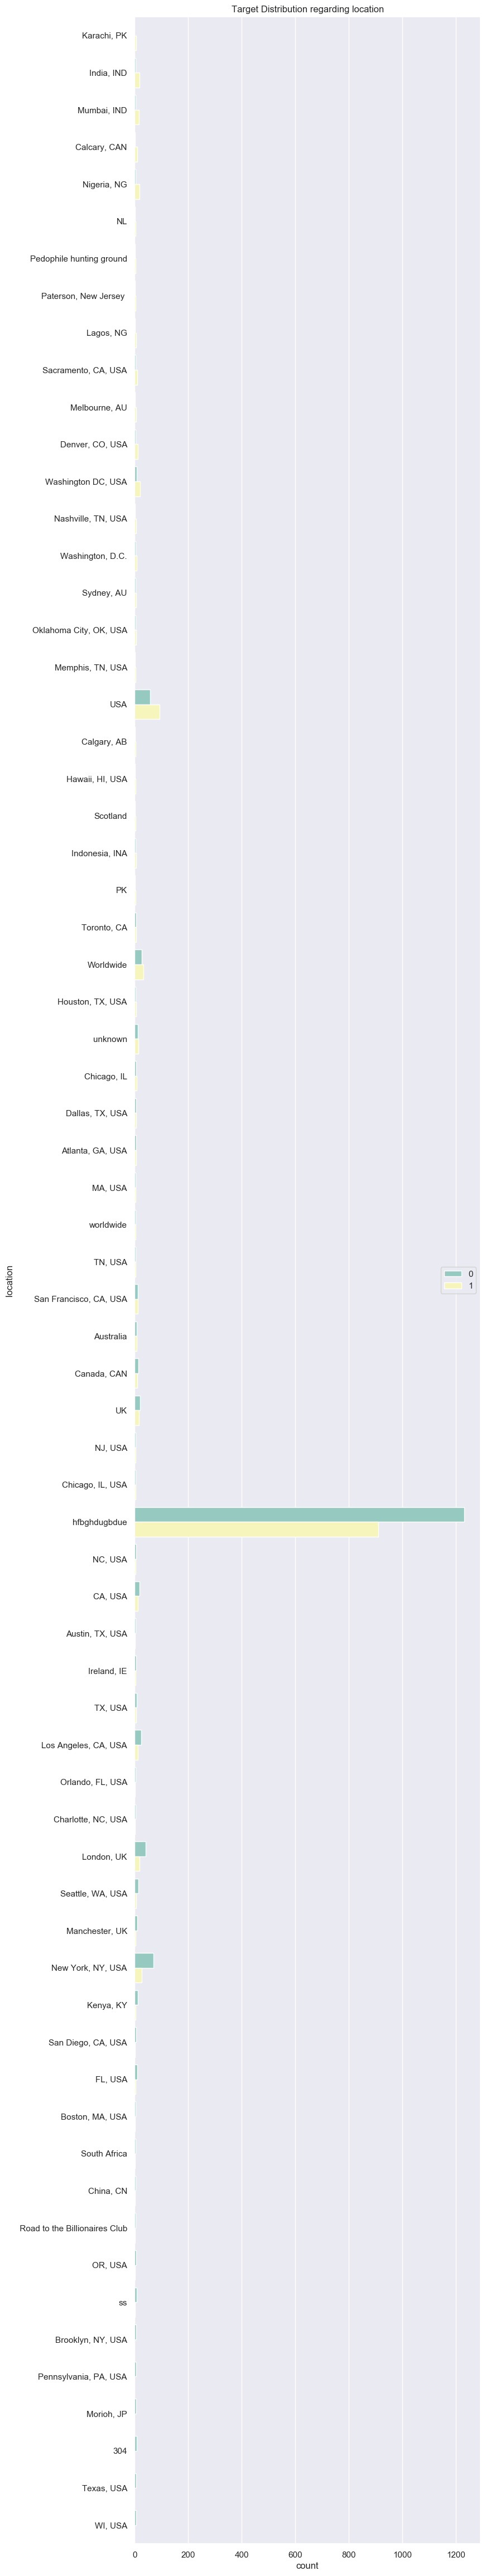

In [ ]:
#Identify which location are mainly related to a specific target and which ones are ambigous 
df_location_selected = df_location_cleaned.copy()
df_location_selected['targetM'] = df_location_cleaned.groupby('location')['target'].transform('mean')

figKey = plt.figure(figsize=(8, 60), dpi=100)

sns.countplot(y=df_location_selected.sort_values(by='targetM', ascending=False)['location'],
              hue=df_location_selected.sort_values(by='targetM', ascending=False)['target'],palette="Set3")

plt.legend()
plt.title('Target Distribution regarding location')

plt.show()

As shown on the previously, some location are highly correlated to the target value and others are more ambigous! Hence we define an heuristic to select only location that is represented more than 90% of the time in one of the target value.

(41, 8)


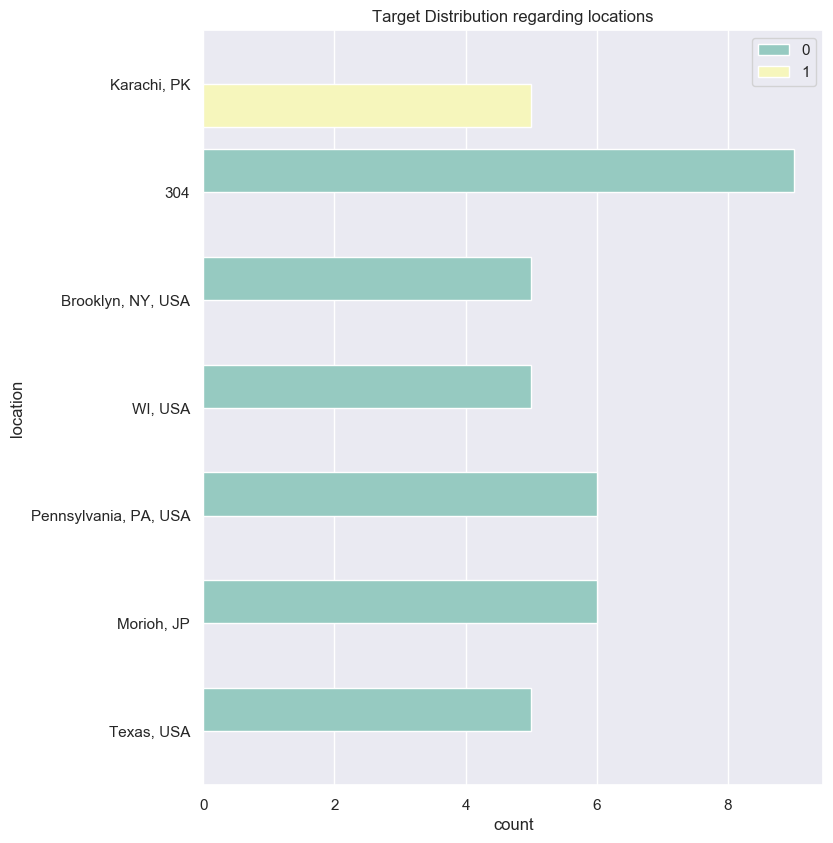

In [ ]:
df_train_selected = df_location_selected[(df_location_selected['targetM'] > 0.9) | (df_location_selected['targetM'] < 0.1)]
print(df_train_selected.shape)

figKey = plt.figure(figsize=(8, 10), dpi=100)

sns.countplot(y=df_train_selected.sort_values(by='targetM', ascending=False)['location'],
              hue=df_train_selected.sort_values(by='targetM', ascending=False)['target'],palette="Set3")

plt.legend()
plt.title('Target Distribution regarding locations')

plt.show()

In [ ]:
#Making a list of most related locations
locations_list = df_train_selected['location'].unique()
locations_list

array(['Brooklyn, NY, USA', '304', 'Pennsylvania, PA, USA', 'Morioh, JP',
       'Karachi, PK', 'WI, USA', 'Texas, USA'], dtype=object)

In [ ]:
# New dataframes

df_train_cleaned["keyword_text_location"] = df_train_cleaned['location'] + ' ' + df_train_cleaned['keyword_cleaned_text'] 
df_train_cleaned["keyword_text_location"] = df_train_cleaned["keyword_text_location"].astype(str)
df_test_cleaned["keyword_text_location"] = df_test_cleaned['location'] + ' ' + df_test_cleaned['keyword_cleaned_text'] 
df_test_cleaned["keyword_text_location"] = df_test_cleaned["keyword_text_location"].astype(str)

def clean_location_text(row):
  if row['location'] in locations_list:
    return row['location'] + ' ' + row['keyword_cleaned_text']
  else:
    return row['keyword_cleaned_text']

df_train_cleaned["keyword_text_location_cleaned"] = df_train_cleaned.apply(clean_location_text, axis=1)
df_test_cleaned["keyword_text_location_cleaned"] = df_test_cleaned.apply(clean_location_text, axis=1)

## Tokenization

In [ ]:
# Same as before

## Modelling

A simple model is used to make some assumptions on Location (regular feature vs selected), selected keywords and text merged and their performance.

**Remark**: the kNN model is used to illustrate our pipeline and is the only model tested on this iteration.

In [ ]:
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'basic', target_col='keyword_text_location', model_type='knn', feature_engineering='tfidf')

The training accuracy is : 0.8249613601236476
The validation accuracy is : 0.7691119691119691


In [ ]:
eval_pipeline_basic(df_train_cleaned, df_test_cleaned, tokenize_function, 'basic', target_col='keyword_text_location_cleaned', model_type='knn', feature_engineering='tfidf')

The training accuracy is : 0.8257341576506955
The validation accuracy is : 0.7791505791505792


**Remark**: Using the full Location feature impacts negativelly our accuracy. Using selected locations increases a little bit our previous result (with kNN). We can keep it.

**Best accuracy score**:

kNN - text + Selected keywords + selected location- TFIDF : 0.77

**Strategic conclusion**:

From iterations 1 to 5 we have noticed a progression in our results. Our final step will be to optimize our models by using merged features: text, selected keywords and selected location. 

**Other technics tried on our basic model (cf. iteration 7)**


*   Working on emojis - Best accuracy score using Logistic - text + selected keywords - Tfidf: 0.804 (↘)
*   Working on spelling corrections - Best accuracy score using Logistic - text - Tfidf: 0.79 (↘↘)



# Iteration 6 - Model and hyperparameters optimization

## Model and hyperparameters optimization using Search Grid Cross Validation

After having tested various strategies, we now try top optimize our model parameters for each technics saw in class: kNN, logistic regression, random forest and decision tree.
We used our conclusion from iteration 5 (selected keywords, selected location and text) to test our models. 

To evaluate the optimal parameters we have used the **SearchGrid Cross Valisation method**. This method is using a parameter space and look for the best combination of those parameters using K-fold cross validation.
The parameters choosen for our tests are the ones that are commonly considered as the most significant for evaluating our models.

Here is our final pipeline with all models:

In [ ]:
def eval_pipeline(df_train, df_test, tokenize_function, name, target_col='keyword', model_type='randomForest', feature_engineering='tfidf', cv=2):
  ''' Eval pipeline '''

  # Make copies to avoid any changes in the main datasets
  train = df_train.copy()
  test = df_test.copy()

  # -------------------------------------- Define the model and parameters space --------------------------------------

  if model_type == 'logisticRegression':
    model = LogisticRegression(random_state=50,
                                n_jobs=multiprocessing.cpu_count())
    
    param_grid = {
        'max_iter': [100, 1000],
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'C': np.logspace(-1, 2, 15),
    }
  
  elif model_type == 'randomForest':
    model = RandomForestClassifier(n_estimators=100,
                                   max_depth=8,
                                   random_state=50,
                                   n_jobs=multiprocessing.cpu_count())
    
    param_grid = { 
        'n_estimators': [100],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [6,7,8],
        'criterion' :['gini', 'entropy']
    }

  elif model_type == 'knn':
    model = KNeighborsClassifier(n_jobs=multiprocessing.cpu_count())
    
    param_grid = { 
        'p': [1, 2],
        'leaf_size': list(range(1,50, 10)),
        'weights': ['uniform'],
        'n_neighbors': list(range(1,30, 5)),
    }
  
  elif model_type == 'decisionTree':
    model = DecisionTreeClassifier()
    
    param_grid = {'max_leaf_nodes': [2, 10, 20, 40, 50, 70, 90],
                  'min_samples_split': [2, 3, 4]}

  # -------------------------------------- Define embeddings --------------------------------------
  if feature_engineering == 'tfidf':
    model = Pipeline([#('vect', CountVectorizer(ngram_range=(1, 3))),
                      ('tfidf', TfidfVectorizer(tokenizer=tokenize_function)),
                      ('clf', model)])

    param_grid = {"clf__"+k:v for k,v in param_grid.items()}
  
  elif feature_engineering == 'w2v':

    # Function that uses w2v embeddings and compute the mean value of all the of w2v vectors of all the words
    def document_vector(doc):
      """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
      tokens = tokenize_function(doc)
      doc = [word for word in tokens if word in feature_vector.wv.vocab]
      return np.mean(feature_vector[doc], axis=0)

    # Create corpus for w2v
    sentences = []
    for text in [list(train[target_col]), list(test[target_col])]:
      for string in text:
        sentences.append(tokenize_function(string))

    # Create w2v embeddings
    feature_vector = gensim.models.Word2Vec(sentences, 
                                            size=100, 
                                            window=10, 
                                            min_count=1, 
                                            iter=20,
                                            seed=50,
                                            workers=multiprocessing.cpu_count()
                                            )

    train[target_col] = train[target_col].apply(document_vector)
    test[target_col] = test[target_col].apply(document_vector)
  
  # -------------------------------------- Split dataset --------------------------------------
  df_train_eval, df_validation = train_test_split(train, test_size=0.2, random_state = 50)

  y_train_eval = df_train_eval[["target"]]
  y_validation = df_validation[["target"]]

  X1_train_eval = list(df_train_eval[target_col])
  X1_validation = list(df_validation[target_col])

  # -------------------------------------- Fit data with grid search hyperparameters optimization --------------------------------------
  CV = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='accuracy',
                    cv=cv,
                    verbose=1,
                    n_jobs=multiprocessing.cpu_count(),
                    )
  
  CV.fit(X1_train_eval, y_train_eval)

  print(f"Best parameters with smaller trainset: {CV.best_params_}")

  # -------------------------------------- Eval data --------------------------------------
  train_accuracy_score = accuracy_score(y_train_eval, CV.predict(X1_train_eval))
  print(f"The training accuracy is : {train_accuracy_score}")

  validation_accuracy_score = accuracy_score(y_validation, CV.predict(X1_validation))
  print(f"The validation accuracy is : {validation_accuracy_score}")

  # -------------------------------------- Retrain on the full dataset --------------------------------------
  y_train = train[["target"]]
  X1_train = list(train[target_col])
  X1_test = list(test[target_col])

  # Create submission file
  CV.fit(X1_train, y_train)
  
  print(f"Best parameters with full trainset: {CV.best_params_}")

  submission = pd.DataFrame(CV.predict(X1_test), columns=["target"])
  submission.to_csv(f'submission_{target_col}_{feature_engineering}_model_{model_type}_{name}.csv', index=False)

In [ ]:
eval_pipeline(df_train_cleaned, df_test_cleaned, tokenize_function, 'optimized', target_col='keyword_text_location_cleaned', model_type='knn', feature_engineering='tfidf', cv=3)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  3.0min
[Parallel(n_jobs=16)]: Done 180 out of 180 | elapsed: 19.7min finished


Best parameters with smaller trainset: {'clf__leaf_size': 1, 'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'uniform'}
The training accuracy is : 0.8033230293663061
The validation accuracy is : 0.7752895752895753
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done 180 out of 180 | elapsed: 28.4min finished


Best parameters with full trainset: {'clf__leaf_size': 1, 'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'uniform'}


**Best parameters for kNN**: 


*   leaf_size: 1
*   n_neighbors: 11
*   p: 2
*   weights: 'uniform'

**Score**: 0.775 (on the smaller trainset)




In [ ]:
eval_pipeline(df_train_cleaned, df_test_cleaned, tokenize_function, 'optimized', target_col='keyword_text_location_cleaned', model_type='logisticRegression', feature_engineering='tfidf', cv=3)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  3.2min
[Parallel(n_jobs=16)]: Done 180 out of 180 | elapsed: 23.0min finished


Best parameters with smaller trainset: {'clf__C': 3.1622776601683795, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}
The training accuracy is : 0.9399149922720247
The validation accuracy is : 0.8046332046332046
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done 180 out of 180 | elapsed: 28.6min finished


Best parameters with full trainset: {'clf__C': 3.1622776601683795, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}


**Best parameters for Logistic Regression**:

*   C: 3.1622776601683795
*   max_iter: 100
*   penalty: 'l2'
*   solver: 'newton-cg'

**Score 1**: 0.805 (on the smaller trainset)

**Score 2**: 0.818 (on the total testset pushed *AICrowd*) 



In [ ]:
eval_pipeline(df_train_cleaned, df_test_cleaned, tokenize_function, 'optimized', target_col='keyword_text_location_cleaned', model_type='randomForest', feature_engineering='tfidf', cv=3)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:  7.4min finished


Best parameters with smaller trainset: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
The training accuracy is : 0.6470247295208655
The validation accuracy is : 0.6471042471042471
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  4.4min
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:  9.0min finished


Best parameters with full trainset: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__max_features': 'auto', 'clf__n_estimators': 100}


**Best Parameters for Random Forest**:

*   criterion: 'gini'
*   max_depth: 8
*   max_features: 'auto'
*   n_estimators: 100

**Score**: 0.647 (on the smaller trainset)

In [ ]:
eval_pipeline(df_train_cleaned, df_test_cleaned, tokenize_function, 'optimized', target_col='keyword_text_location_cleaned', model_type='decisionTree', feature_engineering='tfidf', cv=3)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=16)]: Done  63 out of  63 | elapsed:  8.6min finished


Best parameters with smaller trainset: {'clf__max_leaf_nodes': 70, 'clf__min_samples_split': 2}
The training accuracy is : 0.7712519319938176
The validation accuracy is : 0.7081081081081081
Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  63 out of  63 | elapsed:  9.9min finished


Best parameters with full trainset: {'clf__max_leaf_nodes': 70, 'clf__min_samples_split': 3}


**Best Parameters for Decision Tree**:

*   max_leaf_nodes: 70
*   min_samples_split: 2

**Score**: 0.708 (on the smaller trainset)


**Remarks**: 

As the Logistic Regression is our best model we only submit this one for the total test set on AICrowd. 
 

**Conclusion**: 

With the GridSearch technic we can conclude that the Logistic Regression is our Best model even if it's overfitting. This overfit can be explained by the relative small size of the data set. Moreover, the Logistic Regression doesn't have many parameters to reduce overfitting (regularization only l2, can only work on C) compared to other models that have much more options (random Forest). 

# Iteration 7 - Unsuccessful tries

## Processing

We computed the code below to transform the emojis into text. The first function transforms smileys such as ":)" into text (here smiling_face). The second one transform an emoticon such as 🙂 into the same text as before. 

In [ ]:
#import emojis library
!pip install emot
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

#removing emojis function (emoticons displayed in text)
def convert_emoticons_text(dataFrame):
  len = dataFrame.shape[0]
  i=0
  while i<len:
    for emot in EMOTICONS:
        dataFrame.iloc[i] = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), dataFrame.iloc[i])
    i+=1
  return dataFrame.head(20)

#removing emojis function (emoticons displayed in emojis)
def convert_emoticons_emoji(dataFrame):
  len = dataFrame.shape[0]
  i=0
  while i<len:
    for emot in UNICODE_EMO:
        dataFrame.iloc[i] = dataFrame.iloc[i].replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    i+=1
  return dataFrame.head(20)

In [ ]:
#clean smileys in text

#convert_emoticons_text(df_train['text'])
#convert_emoticons_emoji(df_train['text'])

Since the code took hours to run, we exported the resulting dataset as a csv file into Github and used it directly in the following interations where we needed the dataset free from emojis

In [ ]:
#export new dataframe into csv file

#from google.colab import drive
#drive.mount("drive", force_remount=True)

#df_train_emoji_csv =df_train.to_csv("df_train_emoji.csv")

#!cp df_train_emoji.csv "drive/My Drive/Database_emoji"

Then we created different cleaning functions...
- Correcting spelling mistakes (e.g. transforms caars into cars)
- Removing stop words
- Removing punctuation 
- Removing isolated letters (e.g. "r", "k", "e",...)
- Removing some other elements without importance we found by browsing the data

... and tried each one of them individually to estimate its effect on the accuracy


In [ ]:
# Load English language model
sp = spacy.load('en_core_web_sm')

# Create a list of punctuation marks
punctuations = string.punctuation

# Create a list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Create a list of isolated letters
lonely_letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# Create a list of further elements that could be deleted to improve the model
to_be_deleted = ['http','html','@']

def tokenize_function(text):
    # Create token object, which is used to create documents with linguistic annotations.
    sp_obj = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in sp_obj ]

    # Correcting spelling mistakes
    #mytokens = [ spell(str(word)) for word in sp_obj]

    ## Remove stop words
    #mytokens = [ word for word in mytokens if word not in stop_words]

    # Remove punctuation
    #mytokens = [ word for word in mytokens if word not in punctuations]

    # Remove isolated letters
    #mytokens = [ word for word in mytokens if word not in lonely_letters]

    # Delete further elements
    #mytokens = [ word for word in mytokens if all(char not in word for char in to_be_deleted)]
    
    return mytokens

**Result**:
The more data cleaning we made, the more we lost in accuracy...
Best accuracy: 0.814